In [40]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [41]:
# Load the dataset
data_path = './DataExtraction/cohort_w_confounders.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset and summary statistics
data.describe()

,delirium,duration_hours,subject_id,hadm_id,stay_id,icu_length_of_stay_day,age,weight,avg_dose,max_dose,...,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score,neurological_condition,dementia,vent_duration_hrs
count,3862.000000,3862.000000,3.862000e+03,3.862000e+03,3.862000e+03,3862.000000,3862.000000,3847.000000,3837.000000,3837.000000,...,3860.000000,3855.000000,1407.000000,1790.000000,3862.000000,3599.000000,3779.000000,3861.000000,3862.000000,3862.000000
mean,0.333765,23.956668,1.498533e+07,2.497494e+07,3.494664e+07,4.500329,66.961937,86.834337,2.405498,6.990594,...,4.503886,0.440467,1.496091,2.343017,1.344122,3.739372,4.907118,0.045843,0.022527,78.389582
std,0.471618,37.052958,2.865054e+06,2.880463e+06,2.902654e+06,4.514832,14.657281,22.870271,20.105517,143.498161,...,4.095863,0.869850,3.031570,4.559120,2.013144,3.583342,12.156083,0.209172,0.148410,86.221195
min,0.000000,0.016667,1.000440e+07,2.000015e+07,3.000360e+07,0.541991,18.000000,20.000000,0.300000,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416667
25%,0.000000,4.000000,1.252611e+07,2.253203e+07,3.243603e+07,1.931551,58.000000,71.000000,1.273397,1.801477,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,27.566667
50%,0.000000,10.500000,1.500600e+07,2.493436e+07,3.496709e+07,3.079051,68.000000,84.000000,1.801265,2.424243,...,7.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,51.000000
75%,1.000000,27.170833,1.746738e+07,2.746303e+07,3.741418e+07,5.195804,78.000000,99.100000,2.388665,3.544842,...,7.000000,0.000000,0.000000,5.000000,3.000000,5.000000,0.000000,0.000000,0.000000,92.483333
max,1.000000,358.633333,1.999984e+07,2.999910e+07,3.999862e+07,50.176655,96.000000,254.000000,1020.029007,8147.631226,...,12.000000,4.000000,11.000000,16.000000,9.000000,12.000000,48.000000,1.000000,1.000000,914.066667


In [42]:
len(data)

3862

## check missing values

In [43]:
na_df = data.isnull().sum()*100/len(data)
nadf_reset = na_df.reset_index()
nadf_reset.columns = ['Row Name', 'Missing Percentage']
nadf_reset

,Row Name,Missing Percentage
0,delirium,0.000000
1,duration_hours,0.000000
2,subject_id,0.000000
3,hadm_id,0.000000
4,stay_id,0.000000
5,icu_length_of_stay_day,0.000000
6,age,0.000000
7,weight,0.388400
8,avg_dose,0.647333
9,max_dose,0.647333


In [44]:
missing_values = data.select_dtypes(include=[np.number]).isnull().sum()
numerical_columns_with_missing_values = missing_values[missing_values > 0].index.tolist()

missing_values = data.select_dtypes(include=['object']).isnull().sum()
categorical_columns_with_missing_values = missing_values[missing_values > 0].index.tolist()

In [45]:
categorical_columns_with_missing_values

['marital_status', 'sepsis3']

In [46]:
numerical_columns_with_missing_values

['weight',
 'avg_dose',
 'max_dose',
 'chs_score',
 'temp_score',
 'resp_rate_score',
 'pao2_aado2_score',
 'hematocrit_score',
 'wbc_score',
 'creatinine_score',
 'uo_score',
 'bun_score',
 'sodium_score',
 'albumin_score',
 'bilirubin_score',
 'acidbase_score',
 'gcs_score',
 'neurological_condition']

In [47]:
for column in categorical_columns_with_missing_values:
    mode_value = data[column].mode()[0]  # Using [0] to take the first mode if there are multiple
    data[column].fillna(mode_value, inplace=True)

In [48]:
for column in numerical_columns_with_missing_values:
    mode_value = data[column].median()  # Using [0] to take the first mode if there are multiple
    data[column].fillna(mode_value, inplace=True)

In [49]:
len(nadf_reset[nadf_reset['Missing Percentage']<30]['Row Name'])

35

In [50]:
data = data[nadf_reset[nadf_reset['Missing Percentage']<30]['Row Name']]

In [51]:
len(data.columns)

35

## remove outliers

In [52]:
# Function to remove outliers in a dataframe
def remove_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        lower_bound = df[column].quantile(0.01)
        upper_bound = df[column].quantile(0.99)
        
        # Condition to filter out the outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the function to remove outliers
data = remove_outliers(data)

In [53]:
len(data)

2967

## categorical values

In [54]:
# Convert 'gender' to a numeric format
data['gender'] = data['gender'].map({'M': 1, 'F': 0})

In [55]:
data['race'].value_counts()

race
WHITE                                        1928
UNKNOWN                                       377
BLACK/AFRICAN AMERICAN                        149
OTHER                                         105
UNABLE TO OBTAIN                               64
WHITE - OTHER EUROPEAN                         54
HISPANIC/LATINO - PUERTO RICAN                 40
ASIAN                                          27
PATIENT DECLINED TO ANSWER                     25
ASIAN - CHINESE                                21
BLACK/CAPE VERDEAN                             21
HISPANIC/LATINO - DOMINICAN                    20
WHITE - RUSSIAN                                18
BLACK/CARIBBEAN ISLAND                         17
HISPANIC OR LATINO                             15
ASIAN - SOUTH EAST ASIAN                       12
PORTUGUESE                                      9
ASIAN - ASIAN INDIAN                            8
BLACK/AFRICAN                                   8
WHITE - BRAZILIAN                            

In [56]:
conditions = [
    (data['race'].str.contains('WHITE', case=False)),
    (data['race'].str.contains('BLACK', case=False)),
    (data['race'].str.contains('OTHER|PORTUGUESE|ALASKA|HAWAIIAN|MULTIPLE|SOUTH AMERICAN|ASIAN|HISPANIC|UNKNOWN|UNABLE|DECLINED', case=False))
]
values = ['WHITE', 'BLACK', 'OTHER']

data['race'] = np.select(conditions, values)

In [57]:
data['race'] = data['race'].map({'WHITE': 0, 'BLACK': 1, 'OTHER': 2})

In [59]:
clean_data = data.drop(['vent_duration_hrs', 'icu_length_of_stay_day', 'creatinine_score', 'subject_id', 'hadm_id', 'stay_id', 'admission_type', 'insurance', 'marital_status','age_score', 'gcs_score', 'max_dose', 'apsiii_prob'], axis=1)

In [60]:
clean_data.head()

,delirium,duration_hours,age,weight,avg_dose,gender,race,surgical,apsiii_score,hr_score,...,resp_rate_score,hematocrit_score,wbc_score,uo_score,bun_score,sodium_score,glucose_score,acidbase_score,neurological_condition,dementia
0,1,28.333333,88,56.70,1.210819,0,0,0,51,13,...,0.0,3.0,0.0,5.0,7.0,0.0,5,3.0,0.0,0
1,1,56.516667,35,58.30,2.867659,0,0,1,51,0,...,6.0,3.0,0.0,0.0,0.0,0.0,0,5.0,1.0,0
2,0,180.983333,79,67.25,1.218510,0,0,0,73,0,...,6.0,3.0,0.0,0.0,11.0,0.0,5,12.0,1.0,0
4,0,14.583333,64,99.10,1.887906,1,0,1,28,1,...,6.0,3.0,0.0,5.0,0.0,0.0,3,1.0,0.0,0
5,0,53.583333,46,98.00,3.177271,1,0,1,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,1.0,0


In [61]:
clean_data.columns

Index(['delirium', 'duration_hours', 'age', 'weight', 'avg_dose', 'gender',
       'race', 'surgical', 'apsiii_score', 'hr_score', 'mbp_score',
       'temp_score', 'resp_rate_score', 'hematocrit_score', 'wbc_score',
       'uo_score', 'bun_score', 'sodium_score', 'glucose_score',
       'acidbase_score', 'neurological_condition', 'dementia'],
      dtype='object')

In [62]:
len(clean_data.columns)

22

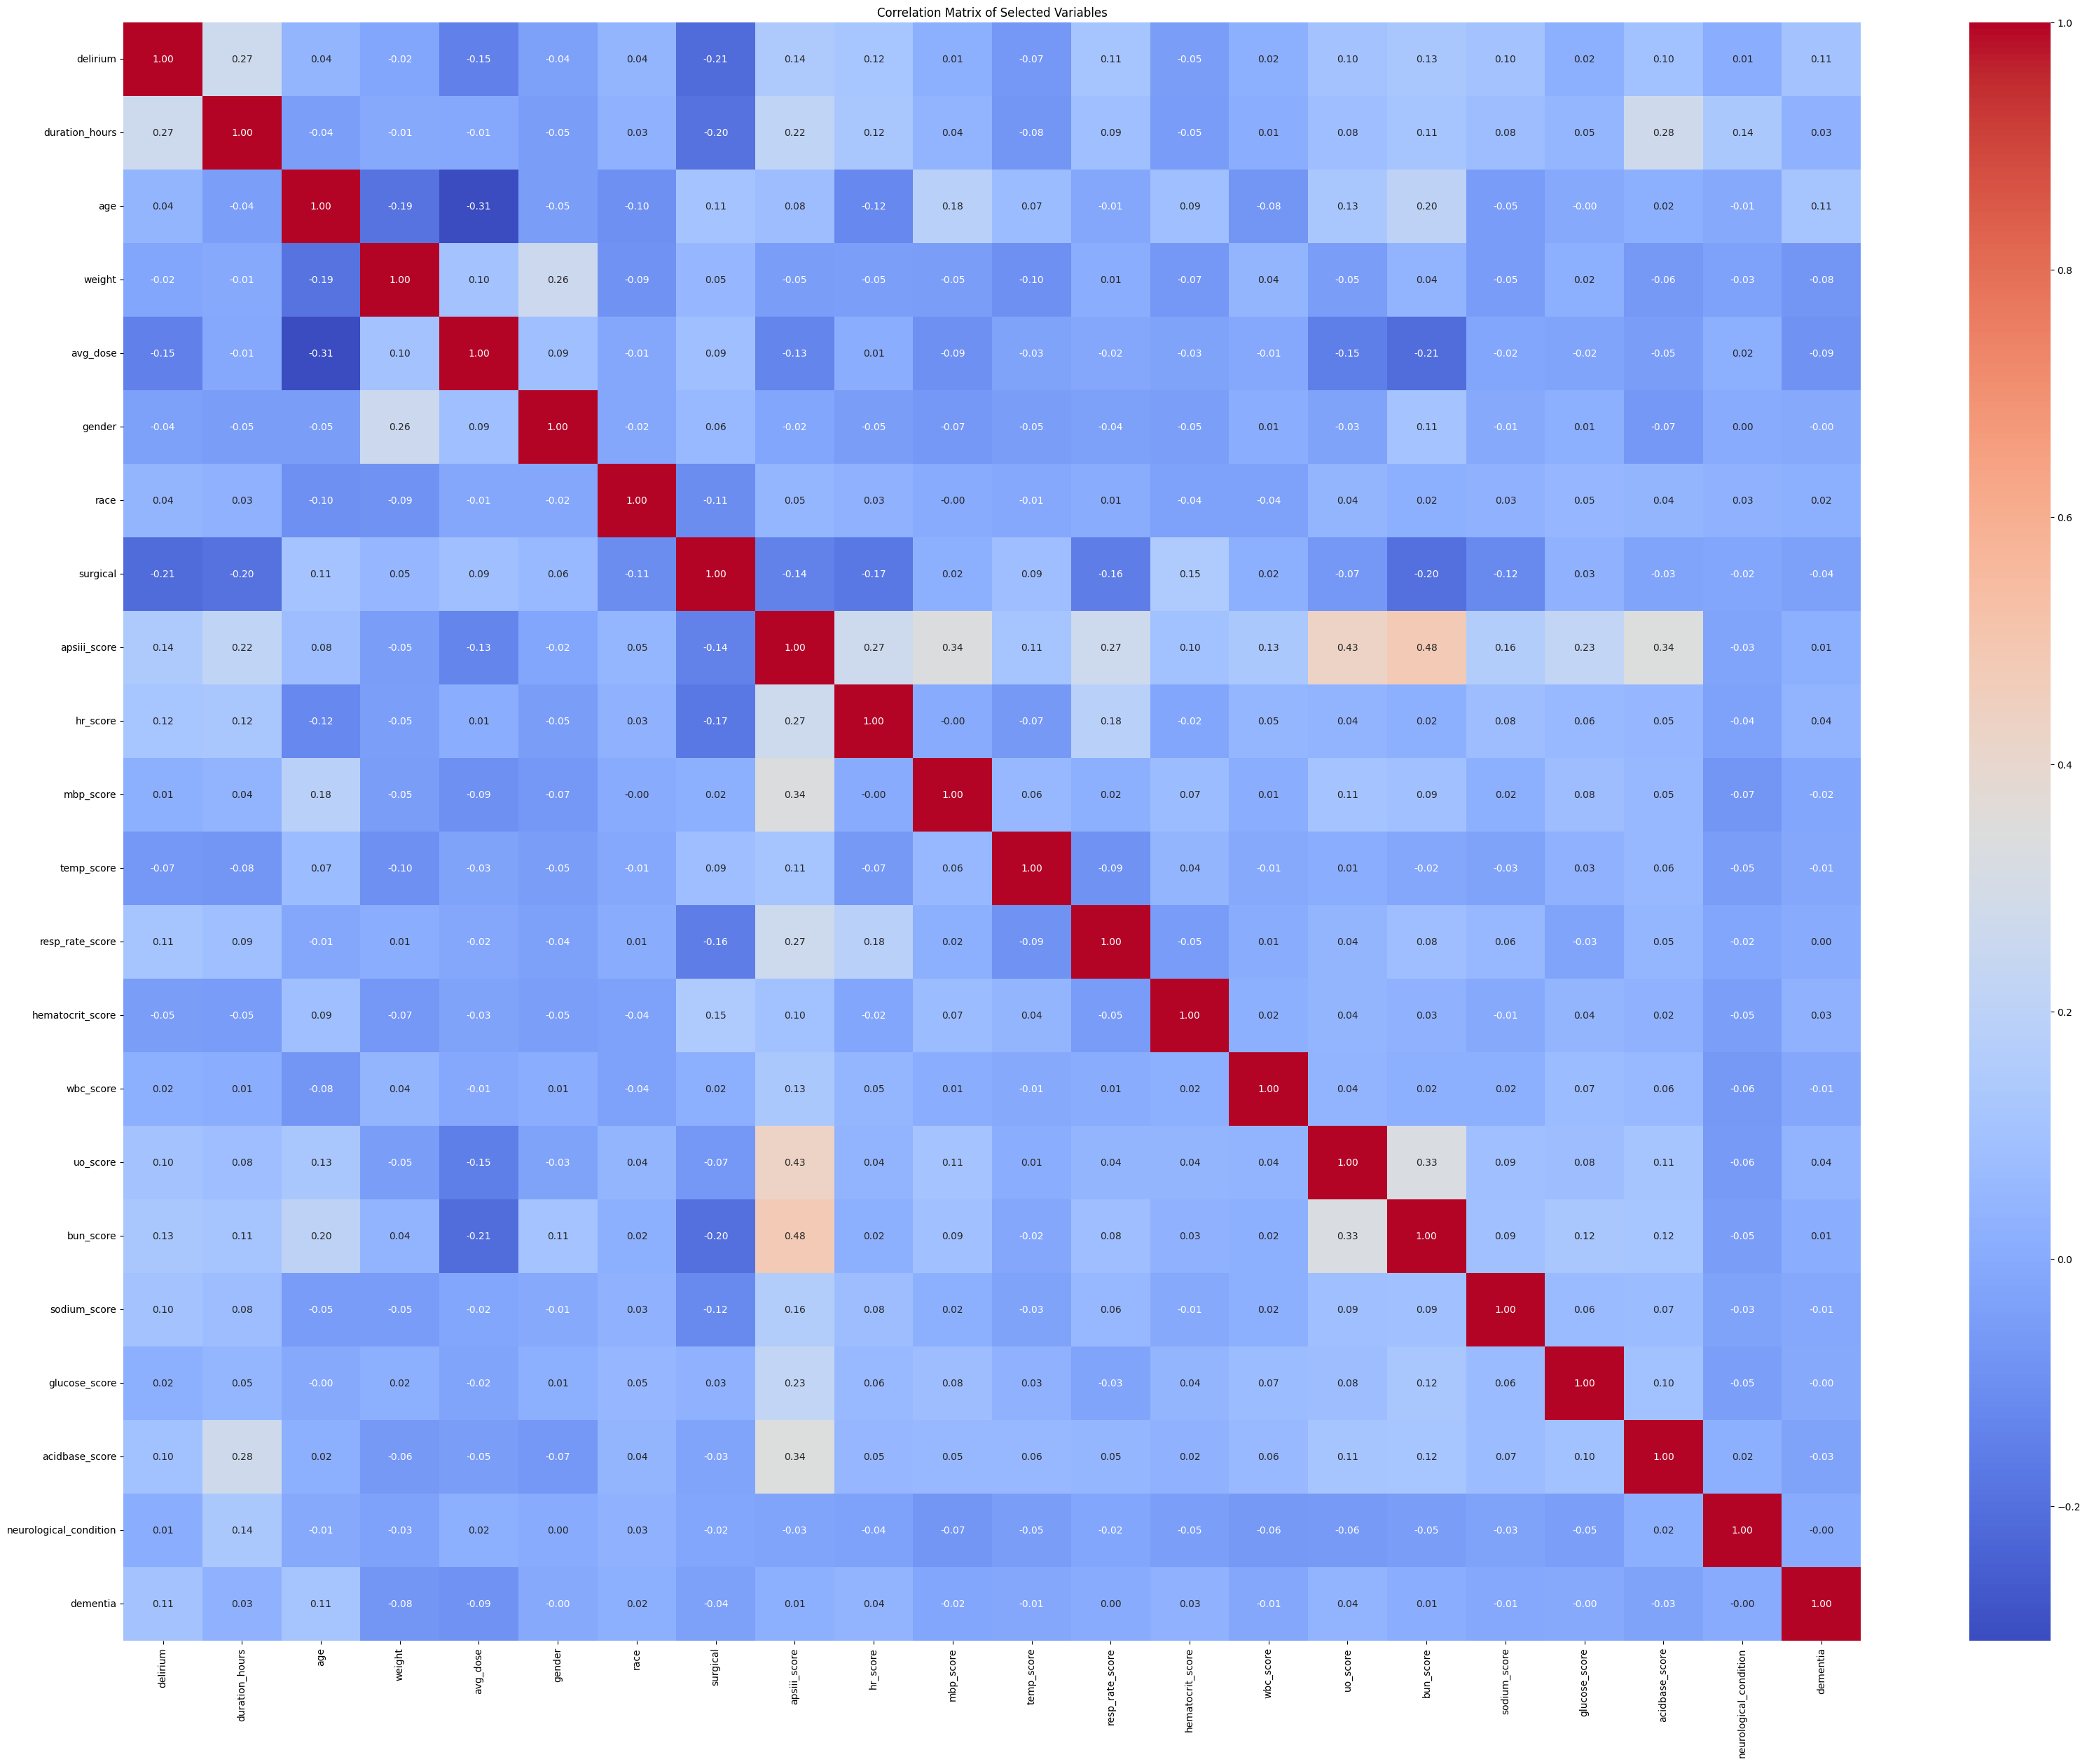

In [63]:
# Correlation matrix

correlation_matrix = clean_data.corr()

# Plot the heatmap
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Variables")
plt.show()

# feature selection

In [64]:
numerical_data = clean_data.select_dtypes(include=[np.number])
# Define the target variable (y) and the features (X)
X = numerical_data.drop('delirium', axis=1)
y = numerical_data['delirium']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute the correlation of each feature with the target variable
correlations = X.corrwith(y)

# Convert to a DataFrame, take the absolute values, and sort by correlation strength
correlations_df = correlations.abs().sort_values(ascending=False).reset_index()
correlations_df.columns = ['Feature', 'Absolute Correlation']

# Display the ranked features based on their absolute correlation with 'aki'
correlations_df

,Feature,Absolute Correlation
0,duration_hours,0.273628
1,surgical,0.213094
2,avg_dose,0.147222
3,apsiii_score,0.143871
4,bun_score,0.129558
5,hr_score,0.118838
6,resp_rate_score,0.112257
7,dementia,0.105251
8,uo_score,0.103149
9,sodium_score,0.102054


In [65]:
candidate_features = correlations_df[correlations_df['Absolute Correlation']>0.05]['Feature']
selected_variables = numerical_data[candidate_features]

X_train, X_test, y_train, y_test = train_test_split(selected_variables, y, test_size=0.2, random_state=42)

## backward selection

In [66]:
# Implementing a basic version of Forward Selection
# Start with no variables and add them one by one
selected_features = []
current_score, best_new_score = 0.0, 0.0

while True:
    scores_with_candidates = []
    for feature in X_train.columns:
        if feature not in selected_features:
            X_train_selected = X_train[selected_features + [feature]]
            X_test_selected = X_test[selected_features + [feature]]
            rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_classifier.fit(X_train_selected, y_train)
            y_pred = rf_classifier.predict(X_test_selected)
            score = accuracy_score(y_test, y_pred)
            scores_with_candidates.append((score, feature))
            print(f'score:{score} candidate:{feature}')
    
    scores_with_candidates.sort(reverse=True)
    best_new_score, best_candidate = scores_with_candidates[0]
    
    if best_new_score > current_score:
        selected_features.append(best_candidate)
        current_score = best_new_score
    else:
        break  # Exit loop if no improvement

selected_features

score:0.6632996632996633 candidate:duration_hours
score:0.6818181818181818 candidate:surgical
score:0.5757575757575758 candidate:avg_dose
score:0.6616161616161617 candidate:apsiii_score
score:0.6851851851851852 candidate:bun_score
score:0.6767676767676768 candidate:hr_score
score:0.6734006734006734 candidate:resp_rate_score
score:0.696969696969697 candidate:dementia
score:0.6818181818181818 candidate:uo_score
score:0.6868686868686869 candidate:sodium_score
score:0.6818181818181818 candidate:acidbase_score
score:0.6818181818181818 candidate:temp_score
score:0.6818181818181818 candidate:hematocrit_score
score:0.6683501683501684 candidate:duration_hours
score:0.6885521885521886 candidate:surgical
score:0.5841750841750841 candidate:avg_dose
score:0.6734006734006734 candidate:apsiii_score
score:0.6919191919191919 candidate:bun_score
score:0.6885521885521886 candidate:hr_score
score:0.6868686868686869 candidate:resp_rate_score
score:0.6952861952861953 candidate:uo_score
score:0.7020202020202

['dementia', 'sodium_score', 'uo_score', 'temp_score']

## Top 10 feature importance using RF Regressor

In [67]:
# 5-fold cross validation
RF = RandomForestRegressor(random_state =1,criterion="absolute_error",
                           min_samples_split=10,min_samples_leaf=5,n_estimators=100)
RF.fit(X_train,y_train)
pred_values = RF.predict(X_test)
rmse = mean_squared_error(y_test,pred_values)

In [68]:
rmse

0.1841672558922559

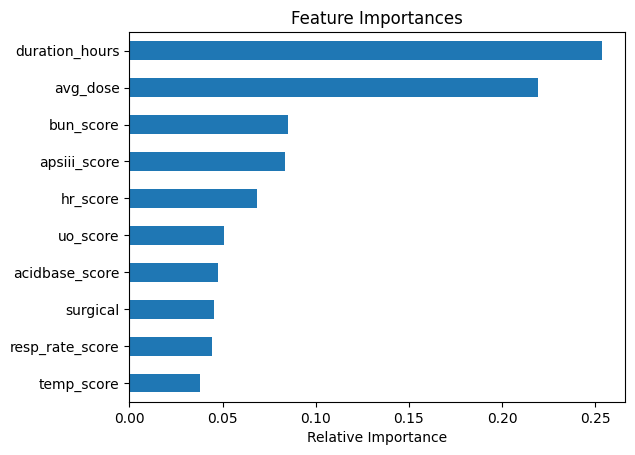

In [69]:
feat_importances = pd.Series(RF.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind = 'barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

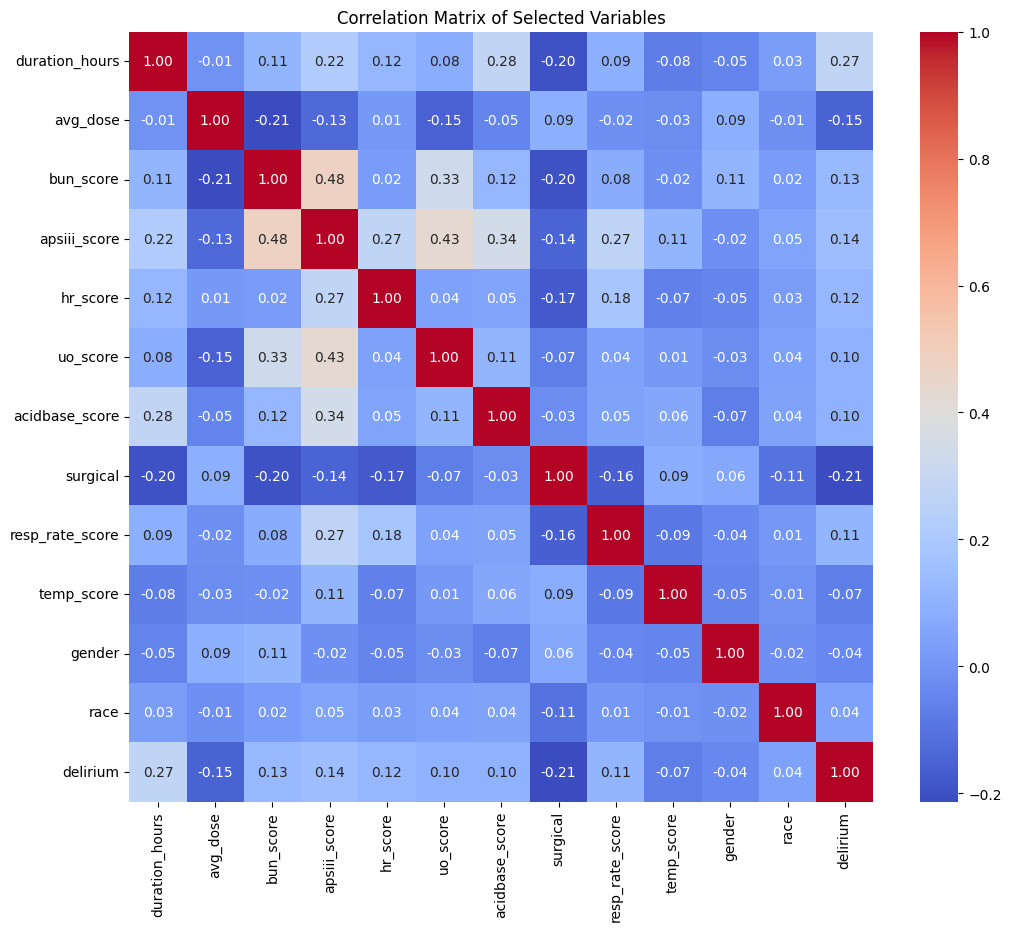

In [70]:
# Select potential confounders and the main variables
selected_columns = feat_importances.nlargest(10).index.tolist()

# Create a smaller dataframe with only selected columns
selected_columns.append('gender')
selected_columns.append('race')
selected_columns.append('delirium')
selected_data = clean_data[selected_columns]

# Correlation matrix
correlation_matrix = selected_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Variables")
plt.show()


# Regression Model

In [71]:
# Prepare the data for modeling
X = selected_data.drop('delirium', axis=1)

y = selected_data['delirium']

# Adding constant for logistic regression with statsmodels
X = sm.add_constant(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Print the summary of the regression
result.summary()


Optimization terminated successfully.
         Current function value: 0.564302
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               delirium   No. Observations:                 2373
Model:                          Logit   Df Residuals:                     2360
Method:                           MLE   Df Model:                           12
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                  0.1050
Time:                        20:44:56   Log-Likelihood:                -1339.1
converged:                       True   LL-Null:                       -1496.2
Covariance Type:            nonrobust   LLR p-value:                 4.799e-60
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5037      0.207     -2.430      0.015      -0.910      -0.097
duration_hours      0.0168      0.002      8.895      0.000       0.013       0.021
avg_dose           -0.3644      0.068     -5.379      0.000      -0.497      -0.232
bun_score           0.0165      0.014      1.183      0.237      -0.011       0.044
apsiii_score        0.0028      0.004      0.781      0.435      -0.004       0.010
hr_score            0.0309      0.014      2.191      0.028       0.003       0.058
uo_score            0.0172      0.015      1.153      0.249      -0.012       0.046
acidbase_score      0.0138      0.015      0.906      0.365      -0.016       0.044
surgical           -0.6716      0.101     -6.638      0.000      -0.870      -0.473
resp_rate_score     0.0386      0.014      2.733      0.006       0.011       0.066
temp_score         -0.0453      0.024     -1.894      0.058      -0.092       0.002
gender             -0.0310      0.098     -0.316      0.752      -0.224       0.162
race                0.0489      0.054      0.906      0.365      -0.057       0.155
===================================================================================
"""